In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
%matplotlib inline


In [13]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

# Reading and Cleaning Data

In [14]:
X=pd.read_csv('data/X.csv')
y=pd.read_csv('data/y.csv')
Cat=pd.read_csv('data/categorical.csv')

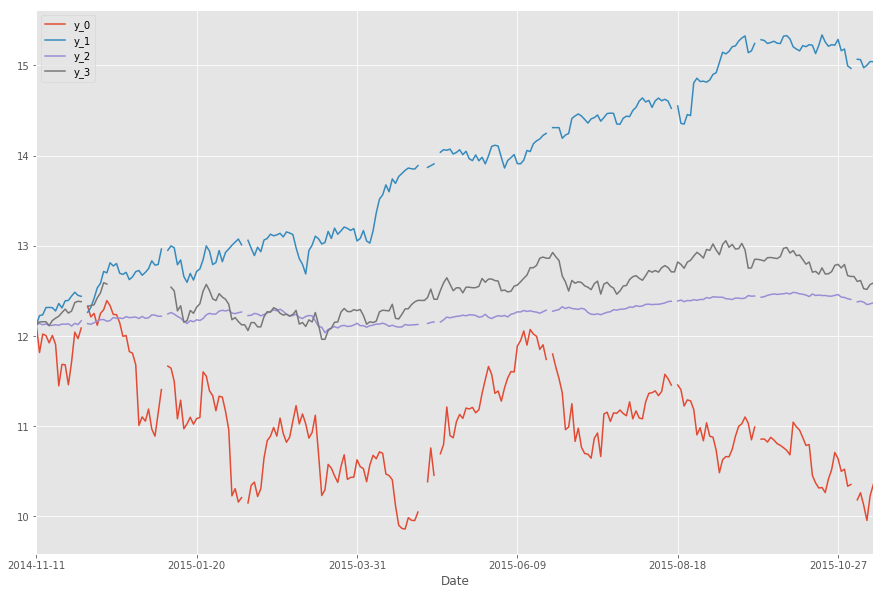

In [15]:
y.set_index('Date').plot(figsize=[15,10])

In [16]:
def clean_create_df(target,X,y):
    df_tmp=pd.merge(X,y[['Date']+[target]],on='Date',how='outer')
    indexnul_morethan1=df_tmp[df_tmp.isnull().sum(1) > 1].index.tolist()
    indexnul_one=df_tmp[df_tmp.isnull().sum(1) == 1].index.tolist()
    # removing all nulls
    if target != 'y_3':
        df_tmp=df_tmp.drop(indexnul_morethan1+indexnul_one)
    else:
        df_tmp=df_tmp.drop(indexnul_morethan1+indexnul_one)
        # days before 2015-01-07 for y_3 is excluded because it has lots of NaN values in the region.
        df_tmp=df_tmp[df_tmp.Date > '2015-01-07']
    return df_tmp

def creating_df(target, X, y, periods=1, pb_cut = 0.5 ) :
    df=clean_create_df(target,X,y)
    
    df_train=df[df.Date < '2015-08-01']
    df_test=df[df.Date >= '2015-08-01']

    df_test=df_test.set_index('Date')
    df_train=df_train.set_index('Date')

    df_train_pct=df_train.pct_change(periods=periods)
    df_train_pct=df_train_pct[df_train_pct.isnull().sum(1) == 0 ]
    df_test_pct=df_test.pct_change(periods=periods)
    df_test_pct=df_test_pct[df_test_pct.isnull().sum(1) == 0 ]
    
    df_corr_y0=df_train_pct.corr()
    columns=df_corr_y0[abs(df_corr_y0[target]) > pb_cut].index.tolist()
    
    return df_train_pct[columns],df_test_pct[columns],df_train[columns],df_test[columns]

def fitting_lasso(df_train_pct,df_test_pct,alpha=0.0001):
    columns=df_train_pct.columns.tolist()
    X_train = df_train_pct[columns[:-1]].values
    y_train = df_train_pct[columns[-1]].values
    
    X_test = df_test_pct[columns[:-1]].values
    y_test = df_test_pct[columns[-1]].values
    
    pipeline = make_pipeline(StandardScaler(),Lasso(alpha=alpha,max_iter=1000,
            positive=True, random_state=9999, selection='random'))
    
    pipeline.fit(X_train, y_train)
    
    linereg=pipeline.get_params()['lasso']
    
    print("r2_score_train=",pipeline.score(X_train, y_train),"r2_score_test=",pipeline.score(X_test, y_test))
    
    non_zero_coeffs=[]
    non_zero_columns=[]
    for i in range(len(columns[:-1])):
        if linereg.coef_[i] > 0:
            non_zero_coeffs.append(linereg.coef_[i])
            non_zero_columns.append(columns[i])
        
    return linereg,non_zero_columns,non_zero_coeffs
    

# The Fitting Result for y_0 

In [17]:
target='y_0'
# days 
periods=1
# We are choosing correlated and anti correlated parameters for preprocessing. 
# We can use the loose cut
pb_cut = 0.5

# cleaning and preprocessing
df_train_pct,df_test_pct,df_train,df_test=creating_df(target, X, y,  periods=periods, pb_cut = pb_cut )

# fitting using lasso. I used Lasso because it has parameter which can force coeffs positive.
# small alpha value is used and it is close to ordinary Least Square regression.
model,columns,coeffs=fitting_lasso(df_train_pct,df_test_pct)
    
for i in range(len(columns)):
    print(columns[i],coeffs[i])
    
ratio=sum(coeffs)
print("Ratio between values of the basket securities and target security  : ",ratio)


r2_score_train= 0.885366582325 r2_score_test= 0.748632566447
x_1 0.00455368384946
x_31 0.00656092300696
x_41 0.0028128011852
x_145 0.000129888085093
x_185 0.00402579845398
Ratio between values of the basket securities and target security  :  0.0180830945807


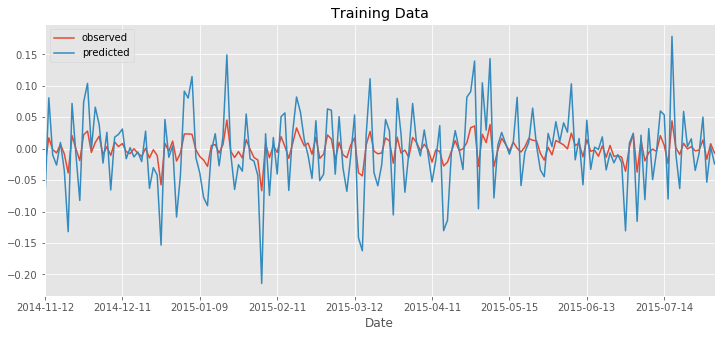

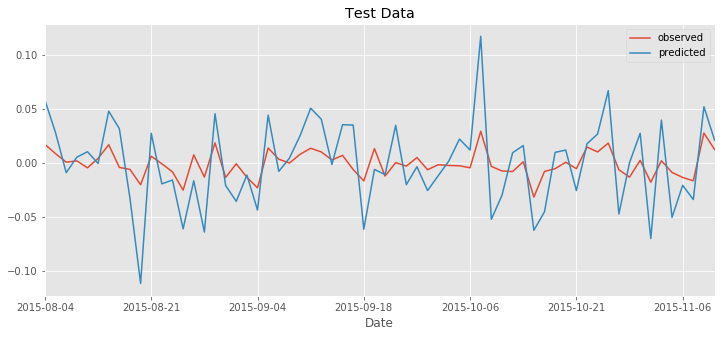

In [18]:
df_pred_train_pct=(df_train_pct[columns]*coeffs/ratio).sum(1)
df_pred_train_pct.columns=[target+'_pred']

df_pred_test_pct=(df_test_pct[columns]*coeffs/ratio).sum(1)
df_pred_test_pct.columns=[target+'_pred']

df_tmp=pd.concat([df_train_pct[target],df_pred_train_pct],1)
df_tmp.columns=['observed','predicted']
df_tmp.plot(figsize=[12,5],title='Training Data')

df_tmp=pd.concat([df_test_pct[target],df_pred_test_pct],1)
df_tmp.columns=['observed','predicted']
df_tmp.plot(figsize=[12,5],title='Test Data')


# The feature study

r2_score_train= 0.898084085379 r2_score_test= 0.733737732118
r2_score_train= 0.909830123199 r2_score_test= 0.800606365149
r2_score_train= 0.915158366845 r2_score_test= 0.753936468023


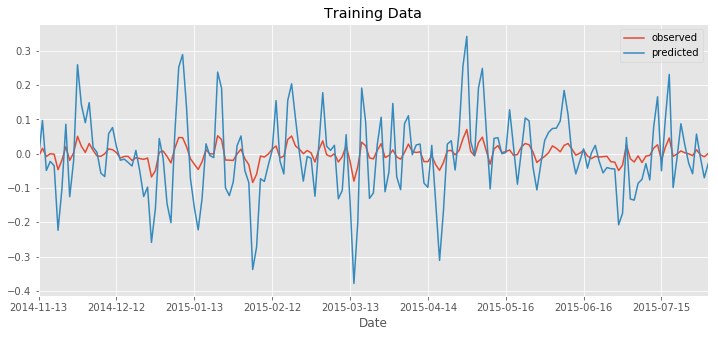

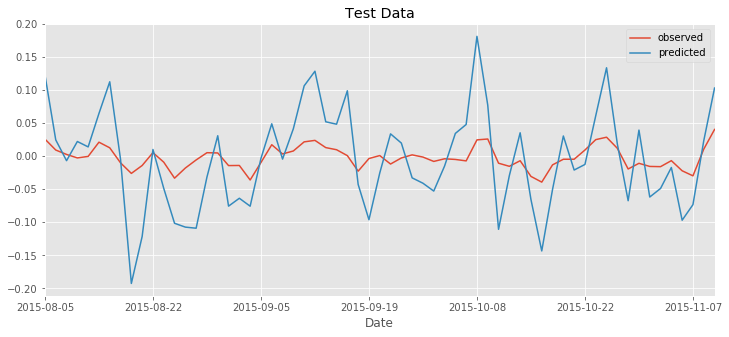

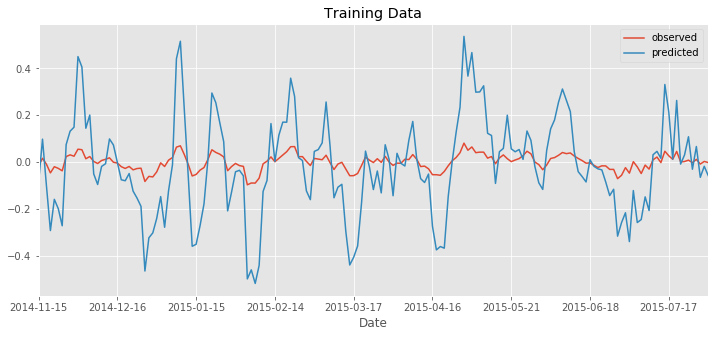

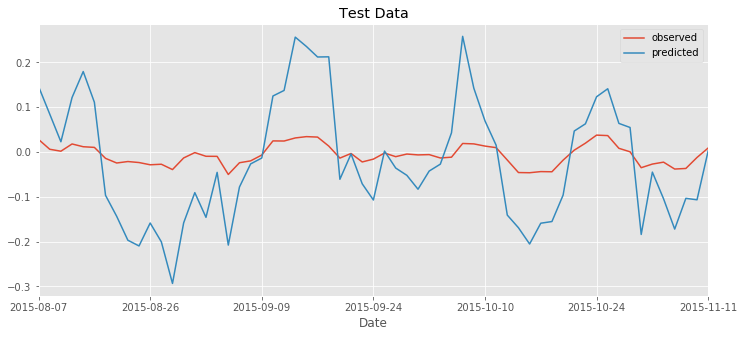

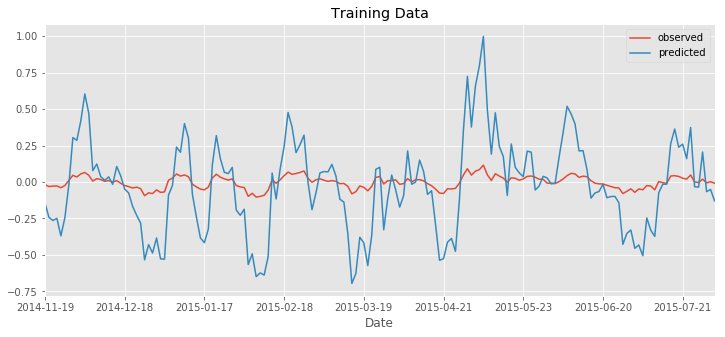

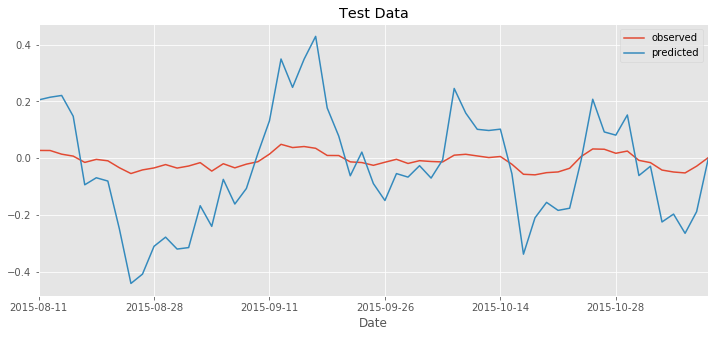

In [19]:
for i in [2,4,6]:
    target='y_0'
    # days 
    periods=i
    # We are choosing correlated and anti correlated parameters for preprocessing. 
    # We can use the loose cut
    pb_cut = 0.5
    
    # cleaning and preprocessing
    df_train_pct,df_test_pct,df_train,df_test=creating_df(target, X, y,  periods=periods, pb_cut = pb_cut )

    # fitting using lasso. I used Lasso because it has parameter which can force coeffs positive.
    # small alpha value is used and it is close to ordinary Least Square regression.
    model,columns,coeffs=fitting_lasso(df_train_pct,df_test_pct)

    df_pred_train_pct=(df_train_pct[columns]*coeffs/ratio).sum(1)
    df_pred_train_pct.columns=[target+'_pred']

    df_pred_test_pct=(df_test_pct[columns]*coeffs/ratio).sum(1)
    df_pred_test_pct.columns=[target+'_pred']

    df_tmp=pd.concat([df_train_pct[target],df_pred_train_pct],1)
    df_tmp.columns=['observed','predicted']
    df_tmp.plot(figsize=[12,5],title='Training Data')

    df_tmp=pd.concat([df_test_pct[target],df_pred_test_pct],1)
    df_tmp.columns=['observed','predicted']
    df_tmp.plot(figsize=[12,5],title='Test Data')


# The results for y_1, y_2 and y_3

In [20]:
targets=['y_1','y_2','y_3']
pb_cuts=[0.6,0.4,0.6]
columns_all=[]
coeffs_all=[]

for target,pb_cut in zip(targets,pb_cuts):
    print('Fitting ',target)
    print('*************************************************')
    # days 
    periods=1

    # cleaning and preprocessing
    df_train_pct,df_test_pct,df_train,df_test=creating_df(target, X, y,  periods=periods, pb_cut = pb_cut )

    # fitting using lasso. I used Lasso because it has parameter which requires coeffs positive without building constraint.
    # small alpha value is used and it is close to linear regression.
    model,columns,coeffs=fitting_lasso(df_train_pct,df_test_pct)
    
    for i in range(len(columns)):
        print(columns[i],coeffs[i])
    
    ratio=sum(coeffs)
    print("Ratio between values of the basket securities and target security  : ",ratio)
    print(' ')

Fitting  y_1
*************************************************
r2_score_train= 0.740986783588 r2_score_test= 0.698828486422
x_10 0.000829120810975
x_39 0.000453933331012
x_53 0.000122885851463
x_88 0.000284808941499
x_114 0.00131225992868
x_124 0.000446442467938
x_125 0.0011189982968
x_162 0.00130173904635
x_407 0.000748375993294
Ratio between values of the basket securities and target security  :  0.006618564668
 
Fitting  y_2
*************************************************
r2_score_train= 0.271859707442 r2_score_test= -0.148944233026
x_109 9.77829906343e-05
x_221 0.000224776676624
x_270 0.000282197684937
x_295 0.00027485625388
Ratio between values of the basket securities and target security  :  0.000879613606075
 
Fitting  y_3
*************************************************
r2_score_train= 0.583764806426 r2_score_test= 0.391369990503
x_31 0.00251798515738
x_124 0.00254191080639
Ratio between values of the basket securities and target security  :  0.00505989596377
 


# Summary

In [21]:
target='y_0'
# days 
periods=1
# We are choosing correlated and anti correlated parameters for preprocessing. 
# We can use the loose cut
pb_cut = 0.5

# cleaning and preprocessing
df_train_pct,df_test_pct,df_train,df_test=creating_df(target, X, y,  periods=periods, pb_cut = pb_cut )

df_20std_train=pd.rolling_std(df_train, window=20)
df_20mean_train=pd.rolling_mean(df_train, window=20)
df_20norm_train=(df_train-df_20mean_train)/df_20std_train
#df_20norm_train=df_train-df_20mean_train
df_20norm_train=df_20norm_train[df_20norm_train.isnull().sum(1) == 0]

df_20std_test=pd.rolling_std(df_test, window=20)
df_20mean_test=pd.rolling_mean(df_test, window=20)
df_20norm_test=(df_test-df_20mean_test)/df_20std_test
#df_20norm_test=df_test-df_20mean_test
df_20norm_test=df_20norm_test[df_20norm_test.isnull().sum(1) == 0]

model,columns,coeffs=fitting_lasso(df_20norm_train,df_20norm_test)
    
ratio=sum(coeffs)

r2_score_train= 0.93794575666 r2_score_test= 0.361445096226


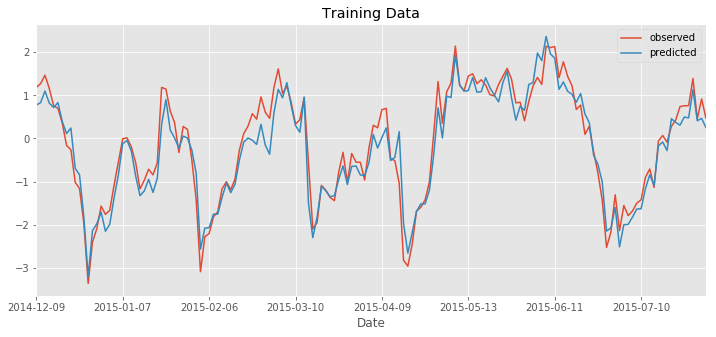

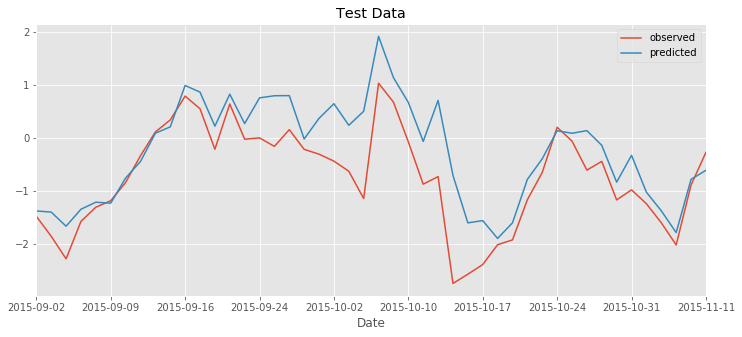

In [22]:
    df_pred_train_pct=(df_20norm_train[columns]*coeffs/ratio).sum(1)
    df_pred_train_pct.columns=[target+'_pred']

    df_pred_test_pct=(df_20norm_test[columns]*coeffs/ratio).sum(1)
    df_pred_test_pct.columns=[target+'_pred']

    df_tmp=pd.concat([df_20norm_train[target],df_pred_train_pct],1)
    df_tmp.columns=['observed','predicted']
    df_tmp.plot(figsize=[12,5],title='Training Data')

    df_tmp=pd.concat([df_20norm_test[target],df_pred_test_pct],1)
    df_tmp.columns=['observed','predicted']
    df_tmp.plot(figsize=[12,5],title='Test Data')